In [1]:
config = {
    'shuffle': False,
    'cell_type': 'E118'
}

In [ ]:
import dgl
import networkx as nx
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import hypertunity as ht
from sklearn import preprocessing

with open('/gpfs_home/spate116/data/spate116/GCN/%s/data/data_class1.pickle' % config['cell_type'], 'rb') as f:
    data = pickle.load(f)
    
with open('/gpfs_home/spate116/data/spate116/GCN/%s/data/data_embedding.pickle' % config['cell_type'], 'rb') as f:
    data_embedding = pickle.load(f)

edges = data.edge_index.t()
adj = list(map(lambda x: (x[0].item(), x[1].item()), edges))

graph = nx.read_gpickle("/gpfs_home/spate116/data/spate116/GCN/%s/data/graph.pickle" % config['cell_type'])
weights = [x[2] for x in graph.edges.data('weight')]
robust_scaler = preprocessing.RobustScaler()
weights = np.ndarray.flatten(robust_scaler.fit_transform(np.array(weights).reshape(-1, 1)))

y = torch.tensor(list(map(lambda x: x[0], data.y)), dtype=torch.long)

G = dgl.DGLGraph(adj)

if config['shuffle']:
    import random
    random.seed(30)
    idx = list(range(len(G.nodes)))
    random.shuffle(idx)
    data_embedding = data_embedding[idx]
    y = y[idx]

G.ndata['feat'] = data_embedding
G.ndata['expr'] = y
G.edata['weight'] = torch.tensor(weights, dtype=torch.float)

Using backend: pytorch


In [ ]:
tot_weights = []
for i in range(len(G.nodes)):
    tmp = 1 if len(G.out_edges(i)[1]) == 0 else sum(list(map(lambda x: G.edges[i, x][0]['weight'][0].item(), G.out_edges(i)[1])))/len(G.out_edges(i)[1])
    tmp = 1 if tmp == 0 else tmp
    tot_weights.append(tmp)

G.ndata['tot_weight'] = torch.tensor(tot_weights, dtype=torch.float)

In [ ]:
def weighted_message(edges):
    val = edges.src['h'] * edges.data['weight'][:, None] / edges.dst['tot_weight'][:, None]
    return {'weighted': val}

In [ ]:
import torch as th
from torch import nn
import dgl.function as fn

class TAGConvWeight(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 k=1,
                 bias=True,
                 activation=None):
        super(TAGConvWeight, self).__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._activation = activation
        self.lin = nn.Linear(in_feats * (self._k + 1), out_feats, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.lin.weight, gain=gain)

    def forward(self, graph, feat):
        assert graph.is_homograph(), 'Graph is not homogeneous'
        graph = graph.local_var()

        norm = th.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = th.reshape(norm, shp).to(feat.device)

        #D-1/2 A D -1/2 X
        fstack = [feat]
        for _ in range(self._k):

            rst = fstack[-1] * norm
            graph.ndata['h'] = rst

            graph.update_all(weighted_message, fn.sum('weighted', 'h'))
            rst = graph.ndata['h']
            rst = rst * norm
            fstack.append(rst)

        rst = self.lin(th.cat(fstack, dim=-1))

        if self._activation is not None:
            rst = self._activation(rst)

        return rst

In [ ]:
from dgl.nn.pytorch import SAGEConv, GraphConv, ChebConv, TAGConv, GATConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_size, aggregator_type='pool', activation=F.tanh)
        self.conv2 = ChebConv(hidden_size, hidden_size1, 5)
        self.conv3 = TAGConv(hidden_size1, hidden_size2, activation=F.leaky_relu)
        self.conv4 = SAGEConv(hidden_size2, hidden_size3, aggregator_type='pool', activation=F.tanh)
        self.conv5 = ChebConv(hidden_size3, hidden_size4, 5)
        self.conv6 = TAGConv(hidden_size4, num_classes, activation=F.leaky_relu)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(g, h)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv3(g, h)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv4(g, h)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv5(g, h)
        h = torch.tanh(h)
        h = F.dropout(h, training=self.training)
        h = self.conv6(g, h)
        h = torch.sigmoid(h)
        return h

In [ ]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

device = torch.device('cuda')
def train_model(net, graph, epochs, learning_rate, train_mask, test_mask):
    model = net.to(device)
    graph = graph.to(device)
    samples = len(graph.ndata['expr'])
    correct = graph.ndata['expr'].cpu().numpy().tolist()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    losses_train = []
    losses_test = []
    best_auc = -1
    correct_pred = [G.ndata['expr'].cpu().numpy()[i] for i in test_mask]
    
    weight_one = sum(G.ndata['expr'].cpu().numpy().tolist())/samples
    weight = torch.tensor([weight_one, 1-weight_one]).to(device)
    
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        logits = model(graph, graph.ndata['feat'].float())

        loss = F.cross_entropy(logits[train_mask], graph.ndata['expr'][train_mask], weight=weight)
        loss_test = F.cross_entropy(logits[test_mask], graph.ndata['expr'][test_mask], weight=weight)
        losses_train.append(loss.item())
        losses_test.append(loss_test.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        pred = list(map(lambda x: np.argmax(x, axis = 0), torch.exp(F.log_softmax(logits, 1)).cpu().detach().numpy()))
        auc = roc_auc_score(correct_pred, [pred[i] for i in test_mask], average='weighted')
        best_auc = best_auc if best_auc > auc else auc

        pbar.set_description('Best Test AUC: %.4f | Train Loss: %.4f | Test Loss: %.4f' % (best_auc, loss.item(), loss_test.item()))
            
    return losses_train, losses_test, model

In [ ]:
import random
random.seed(30)
idx = list(range(len(G.nodes)))
random.shuffle(idx)
train_mask = idx[:10000]
test_mask = idx[10000:]

In [ ]:
net = GCN(94, 1250, 750, 250, 100, 25, 2)

# 0.8220
losses_train, losses_test, model = train_model(net, G, 1250, 0.0001, train_mask, test_mask)

Text(0.5, 1.0, 'nll_loss')

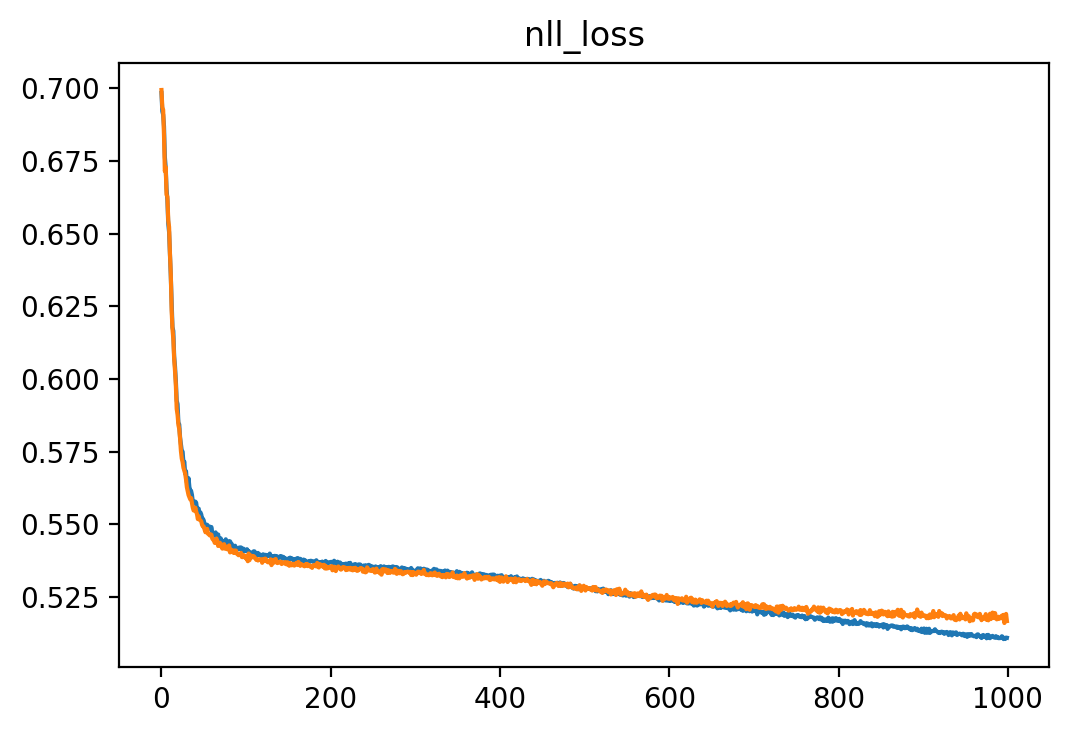

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')
matplotlib.rcParams['figure.dpi'] = 200

plt = sns.lineplot(x = range(len(losses_train)), y = losses_train)
sns.lineplot(x = range(len(losses_train)), y = losses_test)
plt.set_title("nll_loss")

In [10]:
model.eval()
logits = model(G, G.ndata["feat"].float())
pred = list(map(lambda x: np.argmax(x, axis = 0), torch.exp(F.log_softmax(logits, 1)).cpu().detach().numpy()))

print("Test Acc: %.8f" % (sum(np.array([G.ndata['expr'].cpu().numpy()[i] for i in test_mask]) == np.array([pred[i] for i in test_mask]))/len(test_mask)))
print("Total Acc: %.8f" % (sum(G.ndata['expr'].cpu().numpy() == pred)/len(G.nodes)))
print()
print("Test AUC: %.8f" % (roc_auc_score([G.ndata['expr'].cpu().numpy()[i] for i in test_mask], [pred[i] for i in test_mask], average='weighted')))
print("Total AUC: %.8f" % (roc_auc_score(G.ndata['expr'].cpu().numpy(), pred, average='weighted')))

torch.save(torch.tensor(logits, dtype=torch.float), "/gpfs_home/spate116/data/spate116/GCN/%s/data/pred.pt" % config['cell_type'])

Test Acc: 0.90738940
Total Acc: 0.92199235

Test AUC: 0.90687458
Total AUC: 0.92165635


In [11]:
torch.save(model, "/gpfs_home/spate116/data/spate116/GCN/%s/res/best_run.model" % config['cell_type'])